## Santander Customer Transactions predictions

#BigDataSets#HighDimensionality#DataBalancing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta  
import os
import random
import scipy as sp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

import seaborn as sns; sns.set()

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from functions import scaler, threeD_plot, mahalanobis, mahalanobis_vector_plot, compute_mahalanobis_parts , normal_augmentation, concentrated_augmentation
from functions import augmentation_strategy, augmentation_selection_rates, metrics_train_validation, balance_validation, partitions
from functions import unscaler, k_folds_indexs, model_fitting_kfold, weighting_models, jsontotable, plot_results

In [5]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score,accuracy_score,roc_auc_score, roc_curve, auc

### Loading Data

In [7]:
train = pd.read_csv('train.csv')
ss = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [8]:
['var_4', 'var_12', 'var_46', 'var_78', 'var_81', 'var_110', 'var_152', 'var_175', 'var_183', 'var_199']
numerical_features = ['var_4', 'var_12', 'var_46', 'var_78', 'var_81']

<b> random split

In [9]:
seed = 158
validation_dataset = train.sample(frac = 0.25, replace = False, random_state = seed).reset_index(drop = True)
validation_dataset = validation_dataset.copy()[['target'] + numerical_features]
train_dataset = train[~train.index.isin(validation_dataset.index)].reset_index(drop = True)[['target'] + numerical_features]

In [10]:
train_dataset = train_dataset[ ['target'] + numerical_features]

means_train = np.mean(train_dataset[numerical_features])  ### Save this , over not scalled
cov_train = np.cov(train_dataset[numerical_features].T) ### Save thisnot, over not scalled

In [11]:
train_dataset_distance = compute_mahalanobis_parts(train_dataset, numerical_features, 20000,[True,True], means_train, cov_train )
train_dataset_scaled, scalerx = scaler(train_dataset_distance)

<b> validation_dataset is ussed as the test set

<b> sectioning:

In [12]:
train_section_1, train_section_2, train_section_3 = partitions(train_dataset_scaled)

### Cross validation using K-fold and parameter tunning

### Section 1

In [13]:
train_section_1.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
Name: mahalanobis, dtype: int64

In [14]:
dict_1 = {'n':3600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':2000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':4000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_1 =unscaler(train_section_1, scalerx)
train_section_1_aug = augmentation_strategy(data = unscld_train_section_1, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_1
train_section_1_aug =  scaler(train_section_1_aug,scalerx)

In [15]:
train_section_1_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    14376
1     2634
2     3600
3     2000
4     4000
Name: mahalanobis, dtype: int64

In [16]:
train_section_1_aug['mahalanobis'].describe()

count    26610.000000
mean         3.547088
std          2.859279
min          1.269392
25%          1.612200
50%          2.167078
75%          4.449482
max         12.399892
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [17]:
kfolds_touse = k_folds_indexs(train_section_1_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 6000)

In [18]:
train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    6844
1    2102
2    3600
3    2000
4    4000
Name: mahalanobis, dtype: int64

In [19]:
len(train_section_1_aug[train_section_1_aug.index.isin(kfolds_touse['fold 3']['train index'])])

18546

<b> tunning strategy

In [20]:
features_to_use = numerical_features + ['mahalanobis']

#### Section 1: Random Forest

First Try: broad search 

In [ ]:
my_rf_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450,150, 250, 350, 450, 850, 950, 440, 550, 660, 370, 900, 330, 440, 510],
    'max_depth' : [15, 20, 35, 20, 10, 45, 25,35, 75, 65, 18, 29, 35, 45, 25, 55, 60, 65, 15, 65],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35, 60, 15, 20, 36, 50, 60, 24, 35, 15, 12, 24, 22, 44, 18], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35, 12, 30, 18, 10, 14, 8, 10, 22, 17, 32, 8, 15, 26, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48, 0.9, 0.6, 0.2, 0.1, 0.8, 0.6, 0.4, 0.55, 0.10, 0.3, 0.5, 0.44, 0.3, 0.2],
 'sample_aug': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [ ]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

In [33]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

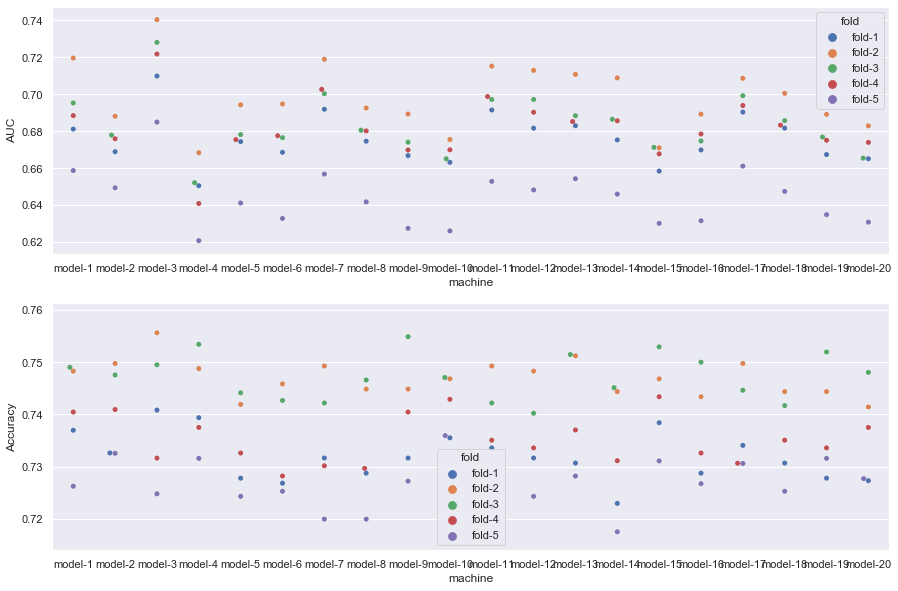

In [34]:
plot_results(toplot_result)

In [35]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.9


second try: reduced scope

In [42]:
my_rf_models = list()
number_of_machines = 5
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 250, 300, 230, 280, 200],
    'max_depth' : [ 35, 30, 28, 25, 30],        
    'min_samples_split' : [ 30, 28, 34, 40, 25], 
    'min_samples_leaf': [ 10, 12, 8, 18, 5 ],
 'rate_aug': [ 1.0, 0.9, 1.0, 1.0, 1.0 ],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [45]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5


In [46]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

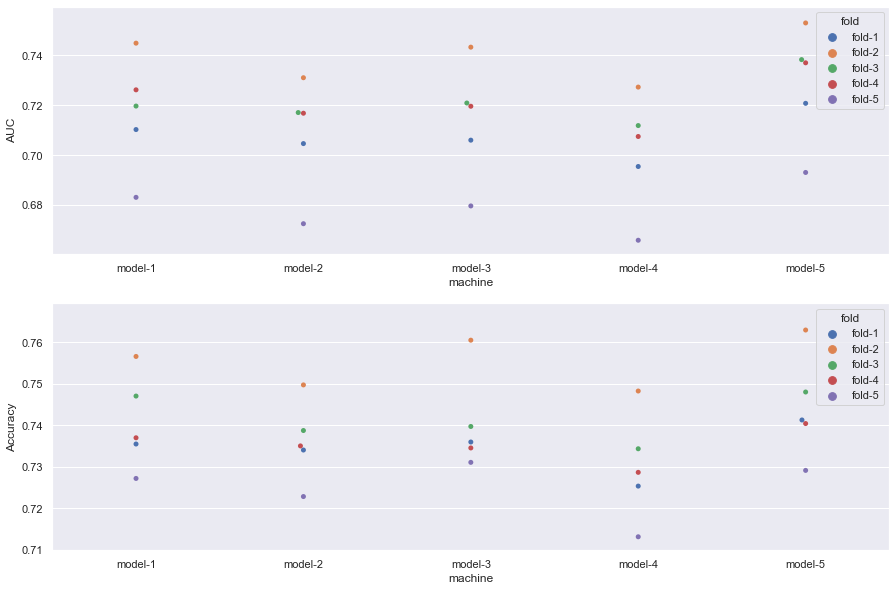

In [47]:
plot_results(toplot_result)

In [49]:
parameters_df[parameters_df.Machine == 'machine-5']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
4,machine-5,200,30,25,5,1.0,0.9


In [51]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 200, 210, 190, 180, 205, 195],
    'max_depth' : [30, 27, 32, 25, 35, 35],        
    'min_samples_split' : [ 25, 24, 21, 29, 35, 20], 
    'min_samples_leaf': [5, 4, 1, 10, 7, 4],
 'rate_aug': [ 1.0 ,1.0, 1.0,1.0, 1.0, 1.0],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [52]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [54]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

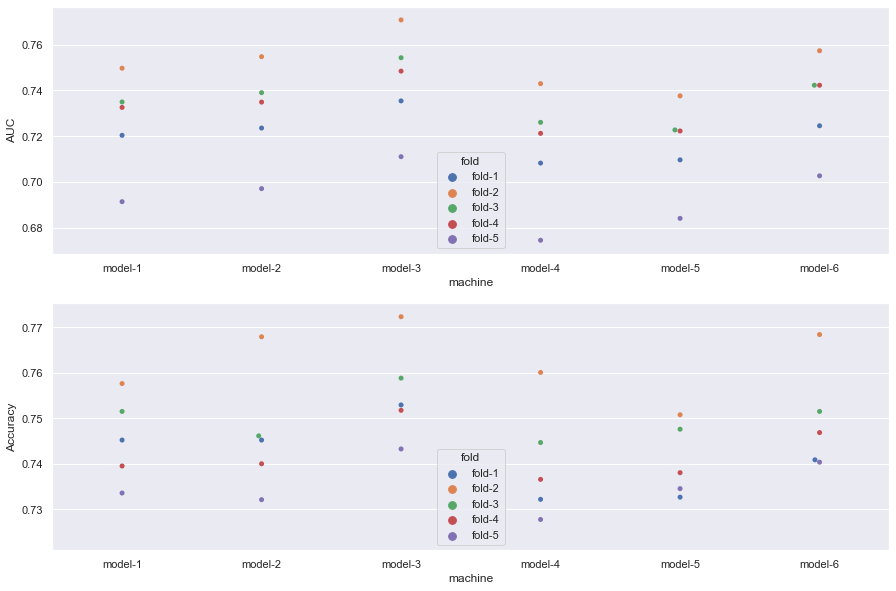

In [55]:
plot_results(toplot_result)

In [56]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,190,32,21,1,1.0,0.9


<b >Final Tunning

In [21]:
my_rf_models = list()
number_of_machines = 6
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [ 190, 185, 195, 170, 190, 180],
    'max_depth' : [ 32, 35, 30, 28, 30, 28],        
    'min_samples_split' : [  21, 18, 20, 15, 25, 20], 
    'min_samples_leaf': [ 1, 4, 2, 4, 1, 1],
 'rate_aug': [ 1.0 ,1.0, 1.0,1.0, 1.0, 1.0],
 'sample_aug': [ 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)

In [22]:
result_tunning, modelsTrained_section_1 = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_1_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'], save_model = True, save_nro_machine = 1)

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6


In [23]:
toplot_result = jsontotable(result_tunning, typex = 'Validation')

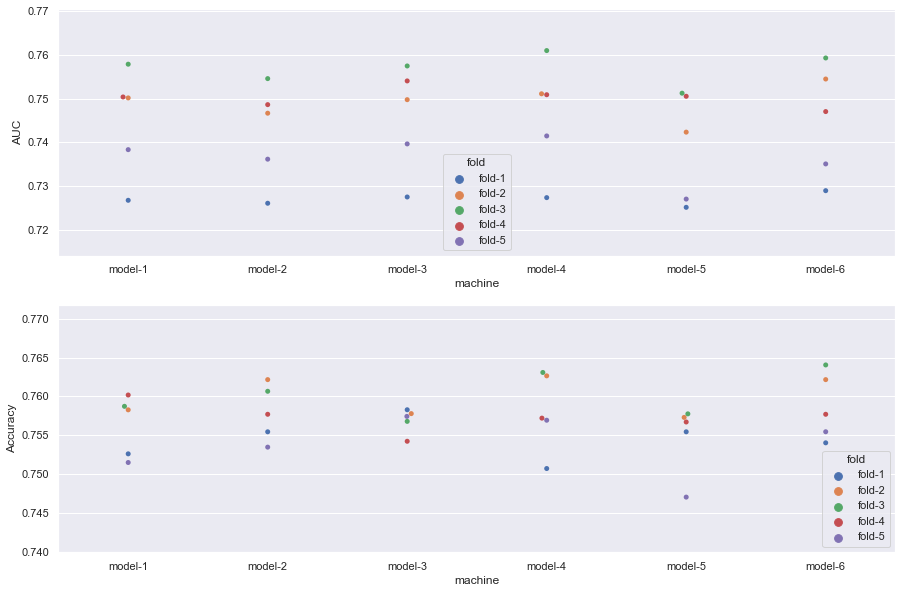

In [24]:
plot_results(toplot_result)

In [25]:
parameters_df[parameters_df.Machine == 'machine-1']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
0,machine-1,190,32,21,1,1.0,0.9


In [26]:
weight_data = train_section_1_aug[train_section_1_aug.target.isin([0,1])]

In [27]:
weighted_section_1_model = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data)
result = weighting_models(models = modelsTrained_section_1 , features = features_to_use, data = weight_data, trained_model = weighted_section_1_model)

In [28]:
roc_auc_score(weight_data.target.values,result)

0.8938912941885341

### Section 2

In [31]:
train_section_2.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
Name: mahalanobis, dtype: int64

In [32]:
dict_1 = {'n':5600, 'range': [15,40], 'label': 2, 'rate': 0.65}  #random augmentation
dict_2 = {'n':4000, 'label': 1} # augmetation on existing ones
dict_3 = {'n':5000, 'range': [15,40], 'label': 4, 'category': 2} # augmetation on the previous ones

unscld_train_section_2 =unscaler(train_section_2, scalerx)
train_section_2_aug = augmentation_strategy(data = unscld_train_section_2, dict_1 = dict_1,dict_2 = dict_2, dict_3 = dict_3,
                      gen_mean = means_train, gen_cov = cov_train, columns_features = numerical_features ).reset_index(drop = True)
del unscld_train_section_2
train_section_2_aug =  scaler(train_section_2_aug,scalerx)

In [33]:
train_section_2_aug.pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    56283
1     6773
2     5600
3     4000
4     5000
Name: mahalanobis, dtype: int64

In [34]:
train_section_2_aug['mahalanobis'].describe()

count    77656.000000
mean         1.201653
std          2.254847
min         -0.253833
25%          0.061976
50%          0.438905
75%          0.942049
max         12.400587
Name: mahalanobis, dtype: float64

<b> Data splitting strategy

In [41]:
kfolds_touse = k_folds_indexs(train_section_2_aug, folds = 5, balanced = True, validation_additional_false = 1000, validation_reduce_false = 25000)

In [42]:
train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])].pivot_table(index = 'target', aggfunc = 'count')['mahalanobis']

target
0    28989
1     5479
2     5600
3     4000
4     5000
Name: mahalanobis, dtype: int64

In [43]:
len(train_section_2_aug[train_section_2_aug.index.isin(kfolds_touse['fold 3']['train index'])])

49068

<b> tunning strategy

In [44]:
features_to_use = numerical_features + ['mahalanobis']

#### Section 2: Random Forest

First Try: broad search 

In [46]:
my_rf_models = list()
number_of_machines = 20
machines_labels = [f'machine-{x}' for x in range(1,number_of_machines +1) ]

parameters = { 'Machine':machines_labels,
    'n_estimators' : [100, 500, 250, 1500, 750, 450,150, 250, 350, 450, 850, 950, 440, 550, 660, 370, 900, 330, 440, 510],
    'max_depth' : [15, 20, 35, 20, 10, 45, 25,35, 75, 65, 18, 29, 35, 45, 25, 55, 60, 65, 15, 65],        
    'min_samples_split' : [10, 20, 30, 15, 25, 35, 60, 15, 20, 36, 50, 60, 24, 35, 15, 12, 24, 22, 44, 18], 
    'min_samples_leaf': [4, 6, 10, 2, 20, 35, 12, 30, 18, 10, 14, 8, 10, 22, 17, 32, 8, 15, 26, 35],
 'rate_aug': [0.5, 0.25, 1.0, 0.0, 0.65, 0.48, 0.9, 0.6, 0.2, 0.1, 0.8, 0.6, 0.4, 0.55, 0.10, 0.3, 0.5, 0.44, 0.3, 0.2],
 'sample_aug': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7] }

for i in range(number_of_machines):
    n_estimators_param = parameters['n_estimators'][i]
    max_depth_param = parameters['max_depth'][i]
    min_samples_split_param = parameters['min_samples_split'][i]
    min_samples_leaf_param = parameters['min_samples_leaf'][i]
    
    my_rf = RandomForestClassifier(n_estimators = n_estimators_param , max_depth = max_depth_param, 
                                   min_samples_split = min_samples_split_param, min_samples_leaf = min_samples_leaf_param)
    my_rf_models.append(my_rf)

parameters_df = pd.DataFrame(parameters)  

In [47]:
result_tunning = model_fitting_kfold(models = my_rf_models , indexes_kfolds = kfolds_touse, features = features_to_use, train_data = train_section_2_aug,
                           rate_aug = parameters['rate_aug'], sample_aug = parameters['sample_aug'])

done machine 1
done machine 2
done machine 3
done machine 4
done machine 5
done machine 6
done machine 7
done machine 8
done machine 9
done machine 10
done machine 11
done machine 12
done machine 13
done machine 14
done machine 15
done machine 16
done machine 17
done machine 18
done machine 19
done machine 20


In [48]:
toplot_result = jsontotable(result_tunning[0], typex = 'Validation')

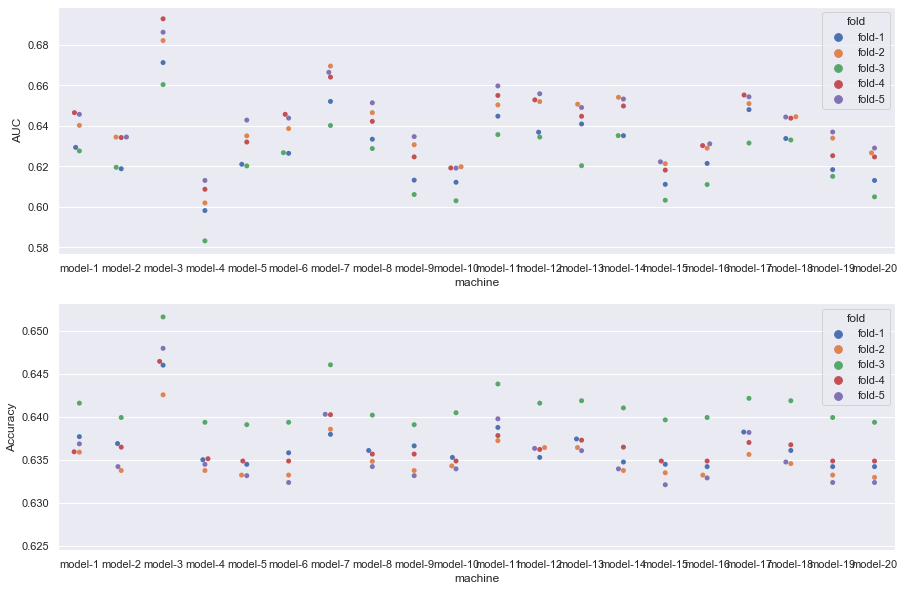

In [49]:
plot_results(toplot_result)

In [50]:
parameters_df[parameters_df.Machine == 'machine-3']

,Machine,n_estimators,max_depth,min_samples_split,min_samples_leaf,rate_aug,sample_aug
2,machine-3,250,35,30,10,1.0,0.7
